In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.ndimage import convolve1d
from scipy.signal.windows import exponential, gaussian
from scipy.signal import square, ShortTimeFFT
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import spikingjelly.clock_driven as cd
import spikingjelly.datasets as sjds
# from spikingjelly.clock_driven import neuron, encoding, functional, layer, surrogate
from spikingjelly.activation_based import neuron, layer, learning

import torchvision.transforms as transforms

import IPython.display as ipd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.io import wavfile


In [3]:
def generate_sound_wave(batch_size=32, num_samples=1.0, sample_rate=44100, 
                        frequencies=[440, 880], amplitudes=[1.0, 0.5],phase_shifts=[0,0],
                        harmonics=1):
    t = np.linspace(0, num_samples/sample_rate, num_samples, endpoint=False)
    # waves = np.zeros_like(batch_size,t)
    waves = np.zeros((batch_size, *t.shape))

    for freq, amp , phase in zip(frequencies, amplitudes, phase_shifts):
        waves += amp * np.cos(2 * np.pi * freq * t + phase)
        for i in range(1, harmonics + 1):
            adj_amp = amp / i
            harmonic_freq = freq * i
            waves += adj_amp * np.sin(2 * np.pi * harmonic_freq * t)
    # add noise to each wave for variety
    waves += 0.1 * np.random.randn(*waves.shape)
    return waves, t

def get_fourier_transform(wave, sample_rate):
    N = len(wave)
    T = 1.0 / sample_rate

    yf = scipy.fftpack.fft(wave)
    xf = np.linspace(0.0,   1.0 / (2.0 * T), N // 2) # Nyquist frequency F/2 = 1/(2*T
    amplitudes = 2.0 / N * np.abs(yf[:N // 2])
    phases = np.angle(yf[:N // 2])

    return xf, amplitudes, phases

def get_fourier_transform_batch(waves, sample_rate):
    batch_size, N = waves.shape
    T = 1.0 / sample_rate

    yf = scipy.fftpack.fft(waves, axis=1)
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)  # Nyquist frequency F/2 = 1/(2*T)
    amplitudes = 2.0 / N * np.abs(yf[:, :N // 2])
    phases = np.angle(yf[:, :N // 2])

    return xf, amplitudes, phases
    
def poisson_spike_encoding(amplitudes, duration, sample_rate, spike_prob_scale=1):
    num_neurons = len(amplitudes)
    num_samples = int(duration * sample_rate)
    # spike_trains = np.zeros((num_neurons, num_samples))
    spik_probs = amplitudes / np.max(amplitudes, axis=0) * spike_prob_scale

    spike_trains = np.random.poisson(spik_probs[..., np.newaxis] * duration, (num_neurons, num_samples))
    spike_trains = np.clip(spike_trains, 0, 1)

    return spike_trains

def poisson_spike_encoding_batch(amplitudes, duration, sample_rate, spike_prob_scale=1):
    batch_size, num_neurons = amplitudes.shape
    num_samples = int(duration * sample_rate)

    # Normalize amplitudes to [0, 1] for probability calculation
    spik_probs = amplitudes / np.max(amplitudes, axis=1, keepdims=True) * spike_prob_scale

    # Generate Poisson-distributed spikes for the entire batch
    spike_trains = np.random.poisson(spik_probs[..., np.newaxis] * duration, size=(batch_size, num_neurons, num_samples))
    
    # Clip spike trains to binary values (0 or 1)
    spike_trains = np.clip(spike_trains, 0, 1)

    return spike_trains

# encode spectrogram in spikes
def range_selectivity_spike_encoding(spectrogram, num_encoding_neurons, kernel, spike_prob_scale=1):
    # Apply the convolution
    spectrogram_conv = convolve1d(spectrogram, weights=kernel, axis=0, mode='constant')
    # try:
    #     spectrogram_conv = spectrogram_conv / np.max(spectrogram_conv)
    # except ZeroDivisionError:
    #     spectrogram_conv = np.zeros_like(spectrogram_conv)
        
    # spectrogram_conv = np.log(spectrogram_conv)
    # normalize it to [0, 1]
    spectrogram_conv = (spectrogram_conv - np.min(spectrogram_conv)) / (np.max(spectrogram_conv) - np.min(spectrogram_conv))

    # spread the encoding neurons across the frequency range of the spectrogram
    # such that each neuron has a selectivity to a range of frequencies
    num_freqs, num_samples = spectrogram.shape
    freq_centers = np.linspace(1, num_freqs, num_encoding_neurons, endpoint=False, dtype=int)
    print("frequencies centers: ", freq_centers)
    spectrogram_conv *= spike_prob_scale

    spike_trains = np.random.poisson(spectrogram_conv[freq_centers, :], size=(num_encoding_neurons, num_samples))
    spike_trains = np.clip(spike_trains, 0, 1)
    
    return spike_trains, freq_centers , spectrogram_conv

def range_selectivity_spike_encoding_batch(spectrograms, num_encoding_neurons, kernel, spike_prob_scale=1):
    batch_size, num_freqs, num_samples = spectrograms.shape
    spike_trains = np.zeros((batch_size, num_encoding_neurons, num_samples))
    freq_centers = None
    convolveed_spectrograms = np.zeros((batch_size, num_freqs, num_samples))
    for i in range(batch_size):
        spike_trains[i], freq_centers, convolveed_spectrograms[i] = range_selectivity_spike_encoding(spectrograms[i], num_encoding_neurons, kernel, spike_prob_scale)
    return spike_trains , freq_centers, convolveed_spectrograms

def plot_spectrogram(spgram, SFT, wave, t, num_samples, g_std, N,title="", with_wave=True):
    if with_wave:
        plt.figure(figsize=(12, 10))
        # plot the wave
        plt.subplot(2,1,1)
        plt.plot(t, wave)
        plt.title('Generated Sound Wave')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        # plot the spectrogram in the second subplot
        plt.subplot(2,1,2)

    Sx_dB = 10 * np.log10(np.fmax(spgram, 1e-3))  # limit range to -40 dB
    t_low, t_high = SFT.extent(num_samples)[:2]
    # print(SFT.extent(num_samples))
    plt.imshow(Sx_dB, aspect='auto', origin='lower', cmap='magma', extent=SFT.extent(num_samples))
    # plt.title('Spectrogram')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Frequency [Hz]')
    plt.title(rf"Spectrogram ({SFT.m_num*SFT.T:g}$\,s$ Gaussian " +
                rf"window, $\sigma_t={g_std*SFT.T:g}\,$s)")
    plt.xlabel(f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
                rf"$\Delta t = {SFT.delta_t:g}\,$s)")
    plt.ylabel(f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
                rf"$\Delta f = {SFT.delta_f:g}\,$Hz)")

    # mark signal borders with vertical lines
    for t_ in [0, num_samples * SFT.T]:
        plt.axvline(t_, color='g', linestyle='--', alpha=0.5)

    plt.colorbar(orientation='vertical', label='Power Spectral Density in dB')
    plt.tight_layout()
    plt.show()

# Generating Surrogate sound Data / Exploration

In [4]:
batch_size = 32
sample_rate = 1000 # f = 1 / T
num_samples = 1000 * 2

duration = num_samples / sample_rate
wave_period = 1/sample_rate

num_freqs = 20
frequencies = np.random.randint(200, 350, size=num_freqs)
amplitudes = np.random.rand(num_freqs)
# amplitudes = np.ones(num_freqs)
phase_shifts = np.zeros(num_freqs)
harmonics = 1

waves, t = generate_sound_wave(batch_size=batch_size, num_samples=num_samples, sample_rate=sample_rate,
                               frequencies=frequencies, amplitudes=amplitudes, phase_shifts=phase_shifts, harmonics=harmonics)

frequencies_1 = np.random.randint(1, 50, size=num_freqs)
waves_1, t = generate_sound_wave(batch_size=batch_size, num_samples=num_samples, sample_rate=sample_rate,
                                 frequencies=frequencies_1, amplitudes=amplitudes, phase_shifts=phase_shifts, harmonics=harmonics)

frequencies_2 = np.random.randint(400, 500, size=num_freqs)
waves_2, t = generate_sound_wave(batch_size=batch_size, num_samples=num_samples, sample_rate=sample_rate,
                                    frequencies=frequencies_2, amplitudes=amplitudes, phase_shifts=phase_shifts, harmonics=harmonics)

# construct a randomlly mixed waves batched by adding the waves together in a random order
# collect num_samples samples from the 3 waves in consecutive order
waves_mix = waves.copy()
waves_mix[:, :num_samples//3] += waves_1[:, :num_samples//3]
waves_mix[:, 2*num_samples//3:] = waves_2[:, 2*num_samples//3:]
# add some noise
waves_mix += np.random.normal(0, 0.1, waves_mix.shape)

print(waves.shape, waves_mix.shape)
sample_wave = waves_mix[0]

g_std = 10      # standard deviation for Gaussian window in samples
win_size = 40   # window size in samples
win_gauss = gaussian(win_size, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win_gauss, hop=2, fs=sample_rate, mfft=2000, scale_to='psd')
# SFT = ShortTimeFFT(win, hop=2, fs=sample_rate, scale_to='psd')
# fet Fourier transform of the wave with ShortTimeFFT (SFT)

spgrams_1 = SFT.spectrogram(waves_mix)  # calculate absolute square of STFT
waves_2 += np.random.normal(0, 0.1, waves_2.shape)
spgrams_2 = SFT.spectrogram(waves_2)

print(spgrams_1.shape, spgrams_1.dtype)

spgrams_1_sample = SFT.spectrogram(sample_wave)
spgrams_2_sample = spgrams_2[0]

(32, 2000) (32, 2000)
(32, 1001, 1019) float64


(2000,)


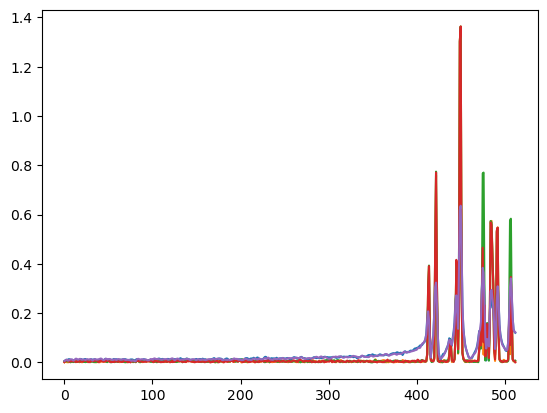

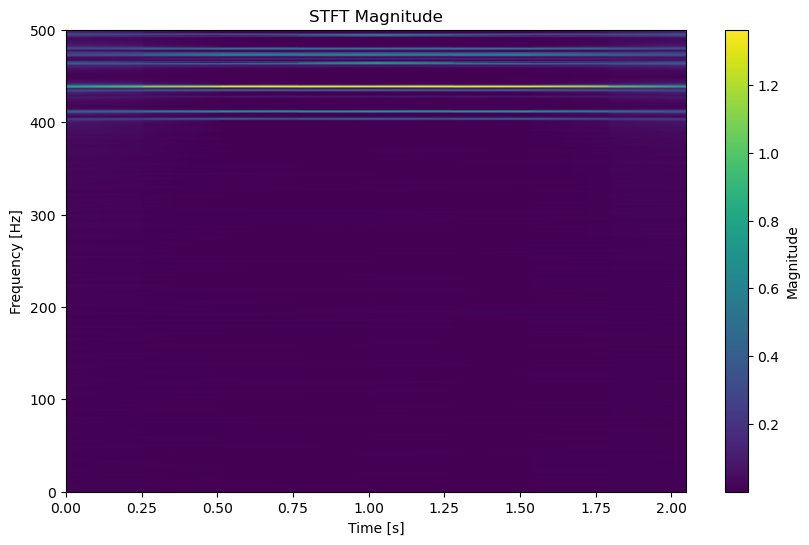

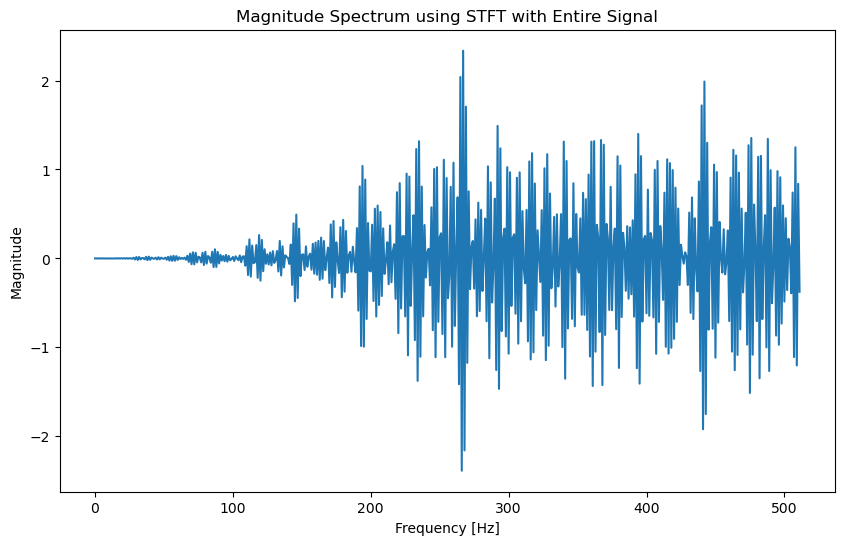

In [5]:
# If the audio is stereo, convert it to mono by averaging the channels
audio_signal = waves_2[0]
print(audio_signal.shape)
if audio_signal.ndim > 1:
    audio_signal = np.mean(audio_signal, axis=1)

# Compute the STFT
frequencies, times, Zxx = stft(audio_signal, fs=sample_rate, nperseg=1024)

# The magnitude of Zxx gives the amplitude of the Fourier coefficients
magnitude = np.abs(Zxx)
# 
plt.plot(magnitude)
plt.show()
# Plotting the STFT magnitude
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, magnitude, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.show()


# Compute STFT with a single segment that covers the entire signal
frequencies, times, Zxx = stft(audio_signal, fs=sample_rate, nperseg=len(audio_signal), noverlap=0, window='boxcar')

_, reconstructed_signal = istft(Zxx, fs=sample_rate, nperseg=1024)

# The magnitude of Zxx gives the amplitude of the Fourier coefficients
magnitude = np.abs(Zxx[:, 0])  # There will be only one column in Zxx

# Plotting the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_signal)
plt.title('Magnitude Spectrum using STFT with Entire Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

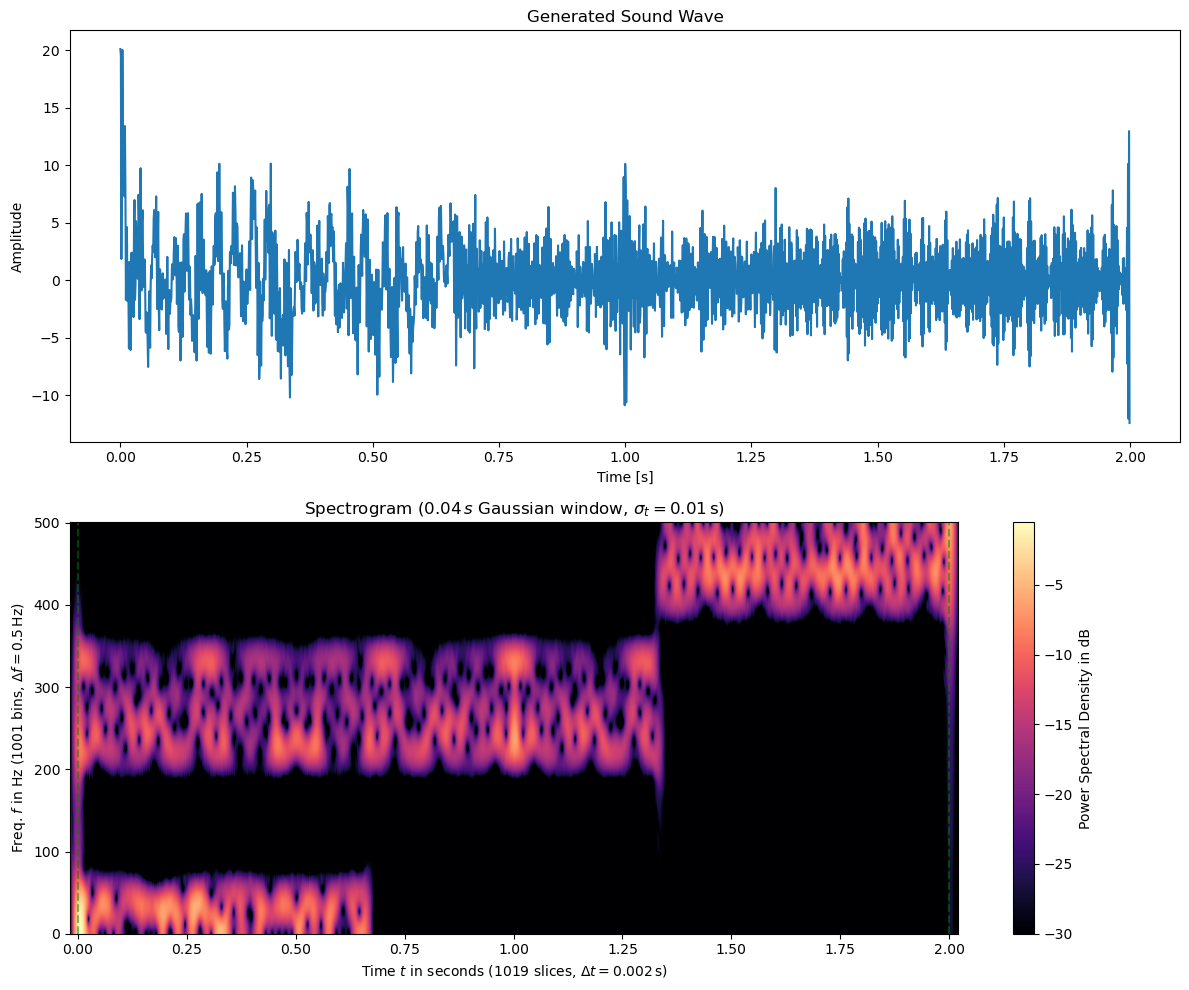

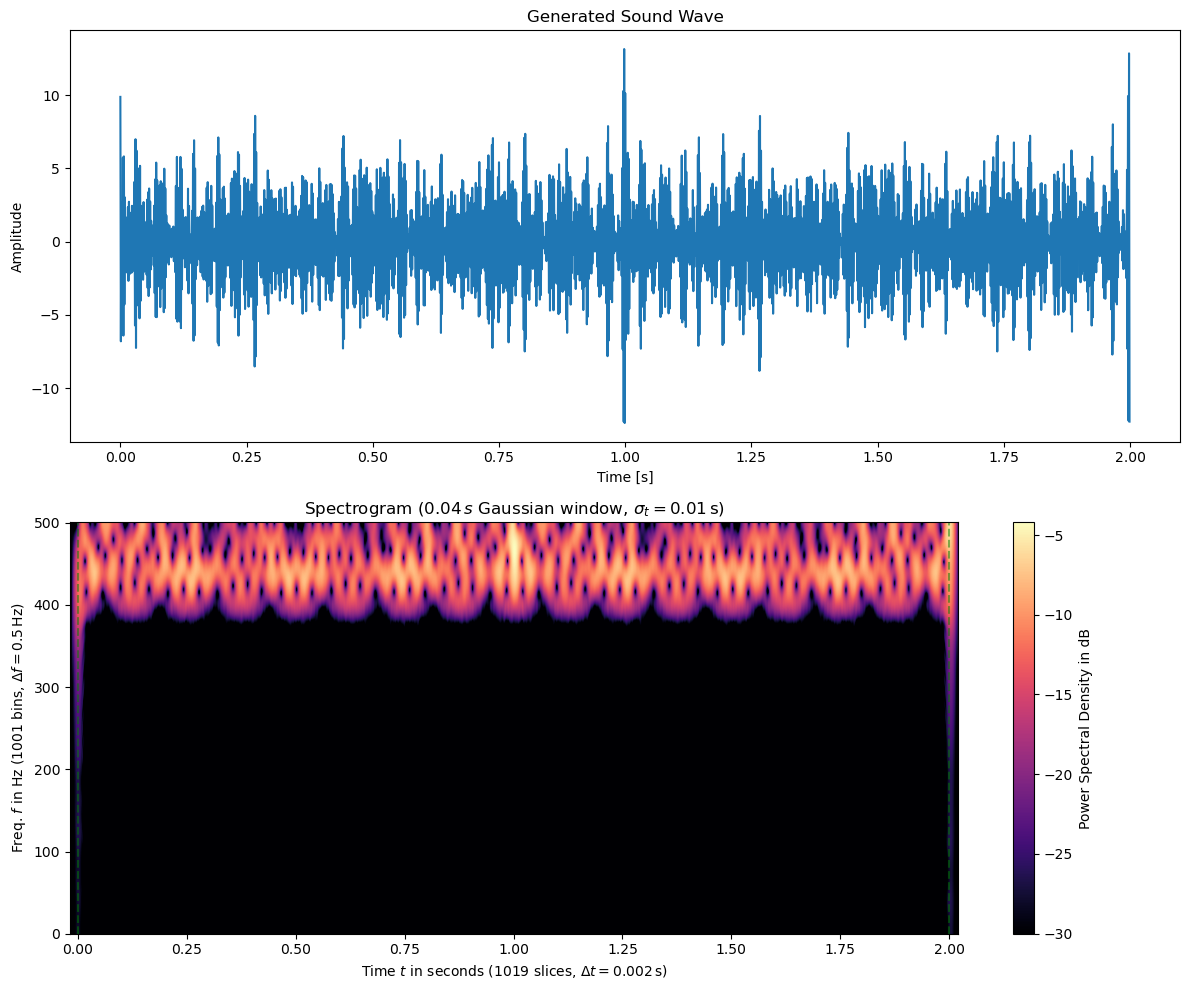

In [6]:
plot_spectrogram(spgrams_1_sample, SFT, sample_wave, t, num_samples, g_std, num_samples, 'Spectrogram 1')
plot_spectrogram(spgrams_2_sample, SFT, waves_2[0], t, num_samples, g_std, num_samples, 'Spectrogram 2')

In [7]:
print(SFT.m_num, SFT.f_pts, SFT.T, SFT.delta_t, SFT.delta_f, SFT.extent(num_samples))


40 1001 0.001 0.002 0.5 (-0.018000000000000002, 2.02, 0.0, 500.5)


In [8]:
num_encoding_neurons = 20
spike_prob_scale = 1.7

kerel_size = 400
tau = 100
g_std = 20

# kernel = exponential(kerel_size, tau=tau, sym=True)
# kernel = gaussian(kerel_size, std=g_std, sym=True)
# combined filter
k_gauss = gaussian(kerel_size, std=g_std, sym=True)
k_exp = exponential(kerel_size, tau=tau, sym=True)
kernel = k_gauss + k_exp
kernel /= np.max(kernel)

spike_trains_1, freq_centers, convolved_spectograms_1 = range_selectivity_spike_encoding_batch(spgrams_1[:2], num_encoding_neurons=num_encoding_neurons,
                                                                      kernel=kernel, spike_prob_scale=spike_prob_scale)
spike_trains_2, freq_centers, convolved_spectograms_2= range_selectivity_spike_encoding_batch(spgrams_2[:2], num_encoding_neurons=num_encoding_neurons,
                                                                      kernel=kernel, spike_prob_scale=spike_prob_scale)

frequencies centers:  [  1  51 101 151 201 251 301 351 401 451 501 551 601 651 701 751 801 851
 901 951]
frequencies centers:  [  1  51 101 151 201 251 301 351 401 451 501 551 601 651 701 751 801 851
 901 951]
frequencies centers:  [  1  51 101 151 201 251 301 351 401 451 501 551 601 651 701 751 801 851
 901 951]
frequencies centers:  [  1  51 101 151 201 251 301 351 401 451 501 551 601 651 701 751 801 851
 901 951]


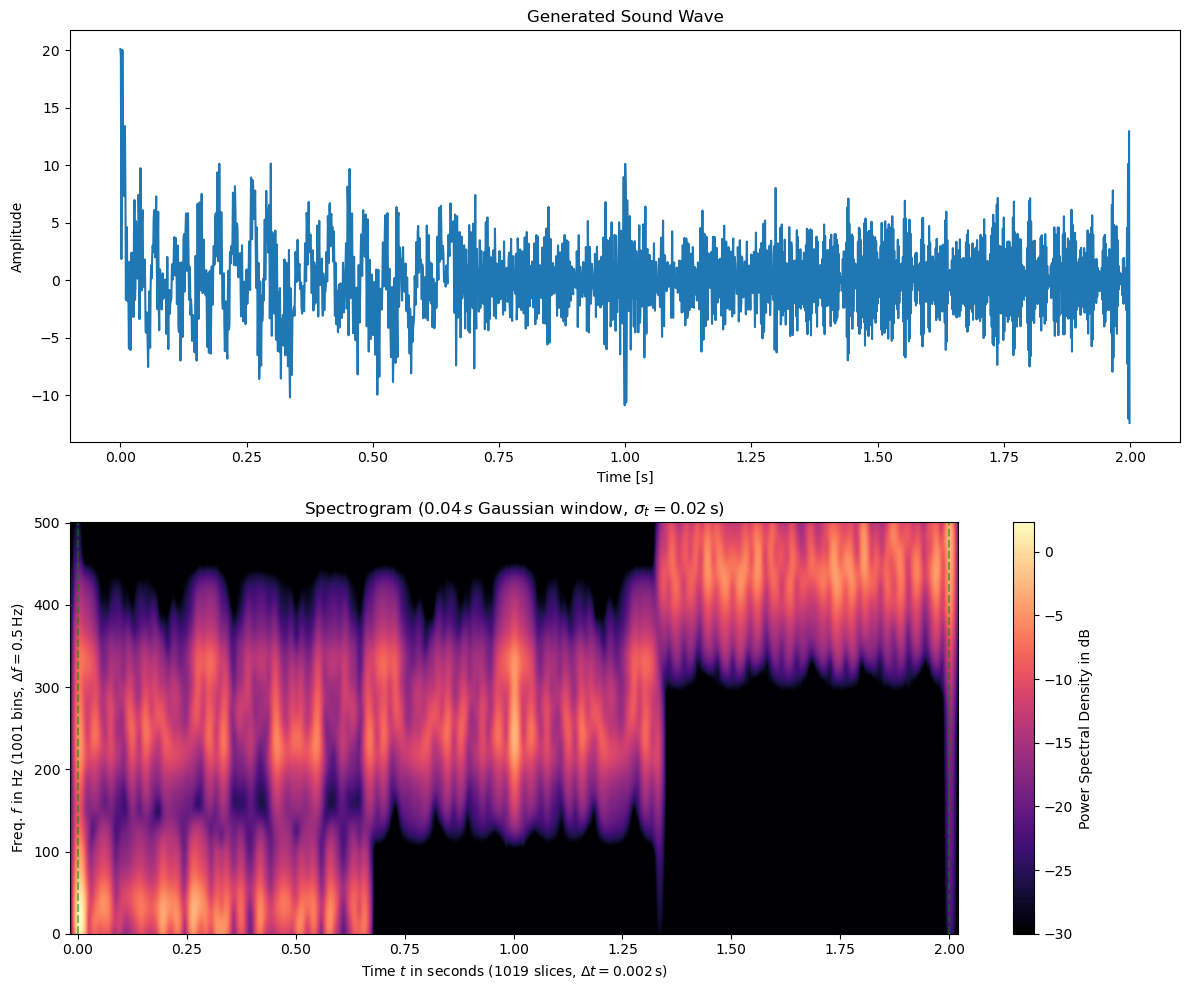

In [9]:
plot_spectrogram(convolved_spectograms_1[0], SFT, waves_mix[0], t, num_samples, g_std, num_samples, 'Convolved Spectrogram 1')

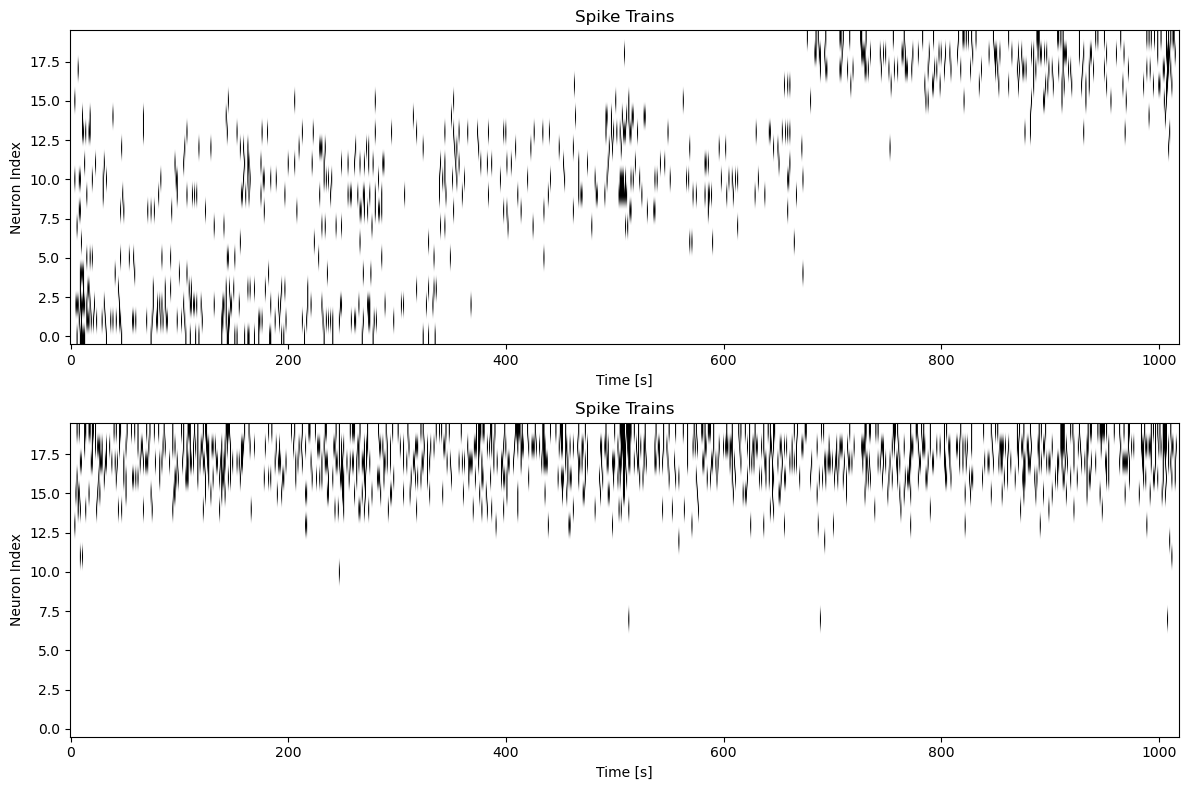

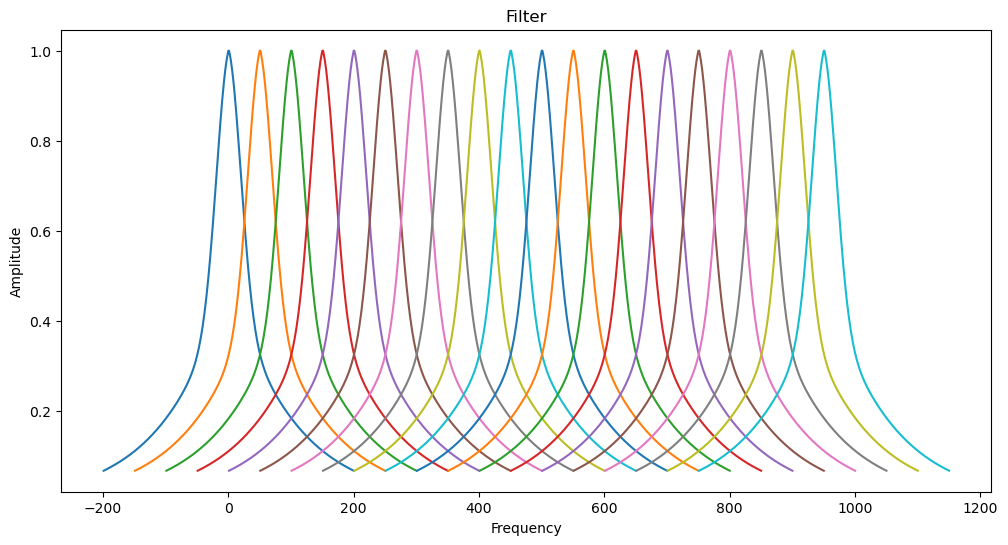

In [10]:
spike_trains_sample_1 = spike_trains_1[0]
spike_trains_sample_2 = spike_trains_2[0]

# Plot the spike trains
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.imshow(spike_trains_sample_1, aspect='auto', origin='lower', cmap='binary')
plt.title('Spike Trains')
plt.xlabel('Time [s]')
plt.ylabel('Neuron Index')

plt.subplot(2,1,2)
plt.imshow(spike_trains_sample_2, aspect='auto', origin='lower', cmap='binary')
plt.title('Spike Trains')
plt.xlabel('Time [s]')
plt.ylabel('Neuron Index')

plt.tight_layout()
plt.show()


# Plot the filter
kernels_xs = []
x_coords = np.arange(kerel_size)
for c in freq_centers:
    k_x = x_coords - (kerel_size/2) + c
    kernels_xs.append(k_x)

plt.figure(figsize=(12, 6))
for k_x in kernels_xs:
    plt.plot(k_x, kernel)
plt.title('Filter')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
# cut at 0
# plt.xlim(0, np.max(k_x))
plt.show()

In [ ]:
from datasets import load_dataset
data = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)

In [12]:
path, samp, samp_rate = data['audio'][0].values()
plt.plot(samp)
plt.show()
ipd.Audio(samp, rate=samp_rate)

In [11]:
def create_individual_kernel(kernel_size, tau, g_std, middle, assume_circular=False):
    # match the kernel size such that middle is in the middle of the kernel
    original_kernel_size = kernel_size
    shift = middle - kernel_size // 2
    if not assume_circular:
        # extend the kernel size to accommodate the shift
        kernel_size = kernel_size + 2*np.abs(shift)

    k_gauss = gaussian(kernel_size, std=g_std, sym=True)
    k_exp = exponential(kernel_size, tau=tau, sym=True)
    combined = k_gauss + k_exp

    if assume_circular:
        combined = np.roll(combined, shift)
    else:
        # crop the kernel to the original size
        if shift < 0: # if negative shift, take the end of the wrapper kernel
            combined = combined[-original_kernel_size:]
        else: # if positive shift, take the beginning of the wrapper kernel
            combined = combined[:original_kernel_size]

    combined /= np.max(combined)  # Normalize the kernel
    return combined

In [21]:
samp, samp_rate = waves_mix[0], sample_rate
g_std = 10      # standard deviation for Gaussian window in samples
win_size = 40   # window size in samples
win_gauss = gaussian(win_size, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT_natural = ShortTimeFFT(win_gauss, hop=2, fs=samp_rate, mfft=4000, scale_to='psd')
spec_natural = SFT_natural.spectrogram(samp)


In [22]:
SFT.f
print(SFT_natural.f.min(), SFT_natural.f.max(), SFT_natural.f_pts, SFT_natural.delta_f)

0.0 500.0 2001 0.25


(2001, 1019)


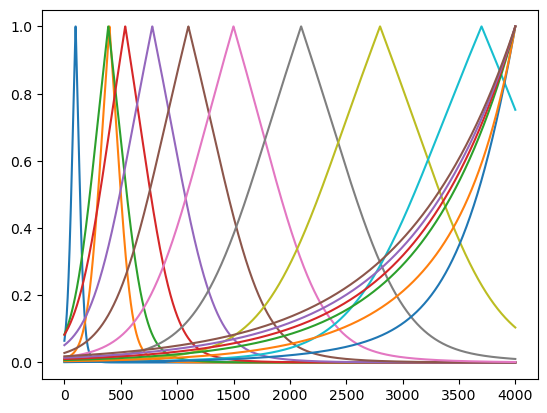

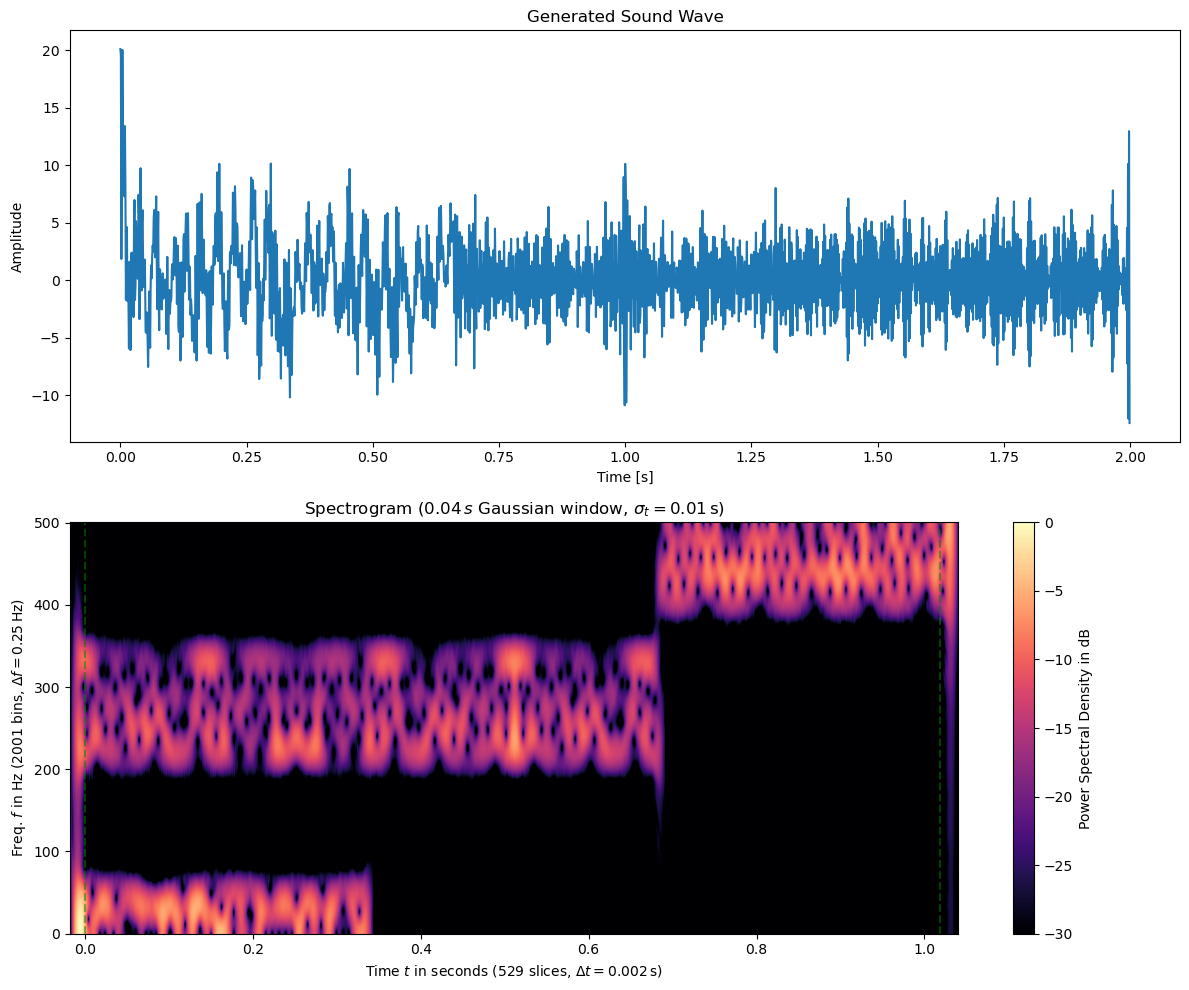

(2001,)
[0.0000e+00 2.5000e-01 5.0000e-01 ... 4.9950e+02 4.9975e+02 5.0000e+02]
(2001,)
(2001,)


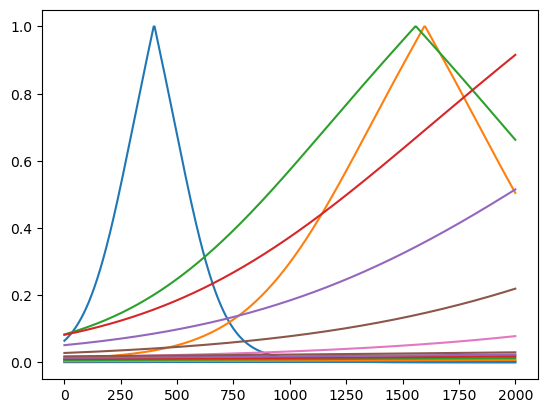

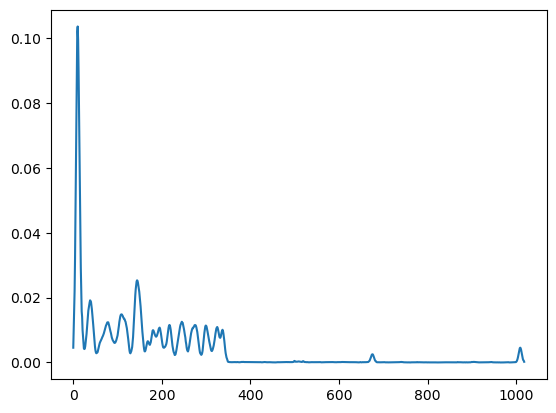

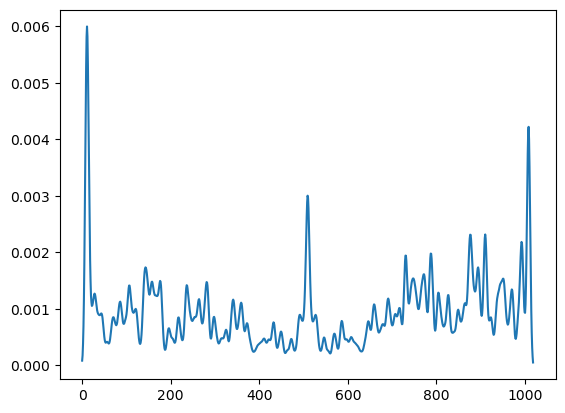

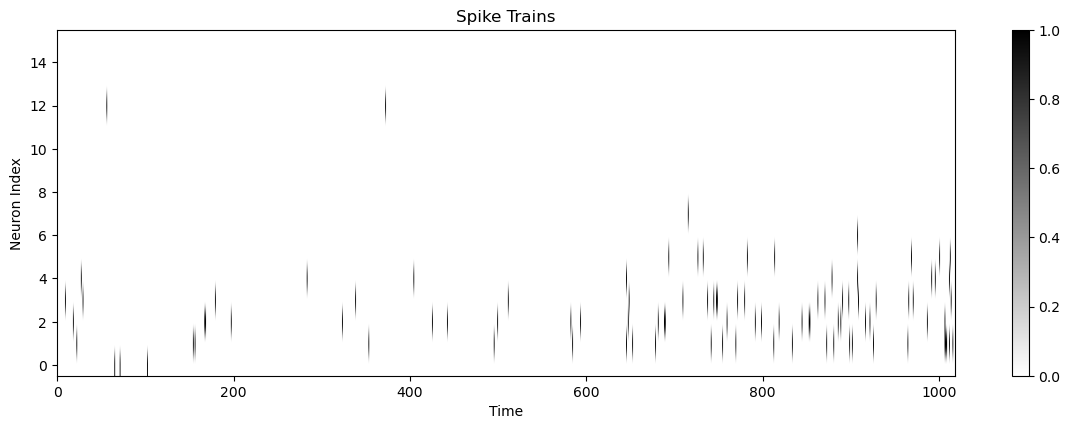

In [26]:
spike_prob_scale = 1.7
# spike trains with individual kernels
params = [
    (400, 40, 100),
    (1040, 104, 400),
    (1680, 168, 390),
    (2320, 232, 540),
    (2960, 296, 780),
    (3600, 360, 1100),
    (4240, 424, 1500),
    (4880, 488, 2100),
    (5520, 552, 2800),
    (6160, 616, 3700),
    (6800, 680, 5000),
    (7440, 744, 6200),
    (8080, 808, 8000),
    (8720, 872, 10000),
    (9360, 936, 13000),
    (10000, 1000, 18000)
]
# params = [(tau, g_std, center) for center in freq_centers]
params = [(tau //10, g_std, center) for tau, g_std, center in params]
# spec_sample = spgrams_1[0]
spec_sample = spec_natural

# normalize the spectrogram
spec_sample = (spec_sample - np.min(spec_sample)) / (np.max(spec_sample) - np.min(spec_sample))

print(spec_sample.shape)
kernels = [create_individual_kernel(len(samp)*2 ,*p) for p in params]
for k in kernels:
    plt.plot(k)
plt.show()

# plot_spectrogram(spec_sample, SFT, waves_mix[0], t, num_samples, g_std, num_samples, 'Spectrogram 1')
t = np.linspace(0, len(samp)/samp_rate, len(samp), endpoint=False)
num_samples = len(spec_sample[0])
plot_spectrogram(spec_sample, SFT_natural, samp, t, num_samples, g_std, num_samples, 'Spectrogram 1') 

# make spike trains for each kernel
spike_prob_scale = 3
spike_trains = np.zeros((len(kernels), spec_sample.shape[1]))

# spec_frequencies = SFT.f
spec_frequencies = SFT_natural.f

print(spec_frequencies.shape)
print(spec_frequencies)
spike_probs_list = np.zeros((len(kernels), spec_sample.shape[1]))
k_list = []
for idx, k in enumerate(kernels):
    k = np.interp(spec_frequencies, np.arange(len(k)), k)
    k_list.append(k)
    scaled_kernel = k * spike_prob_scale
    # filter the spectrogram with the kernel by multiplying element-wise along the time axis
    spike_probs = np.apply_along_axis(lambda x: x * scaled_kernel, 0, spec_sample)

    # plt.imshow(spike_probs, aspect='auto', origin="lower", cmap='magma')
    # # min max
    # plt.title(f'Kernel {idx}, min: {np.min(spike_probs)}, max: {np.max(spike_probs)}')
    # plt.show()
    # plot_spectrogram(spike_probs, SFT_natural, samp, t, num_samples, g_std, num_samples, f'Kernel {idx}', with_wave=False)
    # compress to 1d
    spike_probs = np.average(spike_probs, weights=k, axis=0)
    spike_probs_list[idx, :] = spike_probs

    # plt.plot(spike_probs, label=f'Kernel {idx}, params = {params[idx]}')
    # plt.legend()
    # plt.show()

    spike_train = np.random.poisson(spike_probs)
    spike_train = np.clip(spike_train, 0, 1)
    spike_trains[idx] = spike_train

print(k_list[0].shape)
print(spec_frequencies.shape)
for idx, k in enumerate(k_list):
    plt.plot(k)
plt.show()

plt.plot(spike_probs_list[0], label='Kernel 0')
plt.show()
plt.plot(spike_probs_list[-1], label='Kernel -1')
plt.show()
# Plot the spike trains
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.imshow(spike_trains, aspect='auto', origin="lower",cmap='binary')
plt.colorbar()
plt.title('Spike Trains')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.tight_layout()
plt.show()

spec_sample shape (1001, 1019)
(1001, 1019)


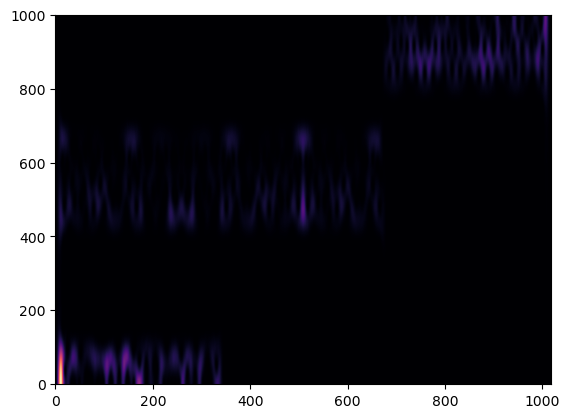

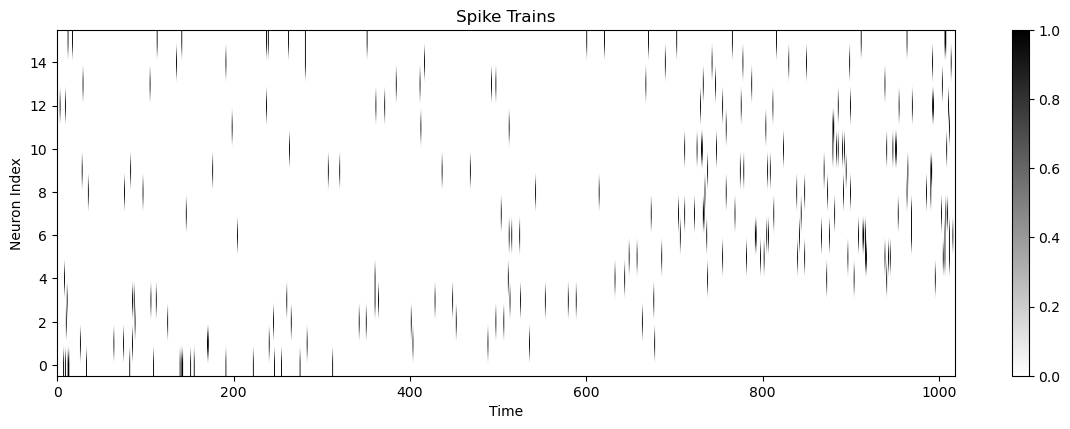

In [27]:
audio = samp
sample_rate = samp_rate

g_std = 10      # standard deviation for Gaussian window in samples
win_size = 40   # window size in samples
win_gauss = gaussian(win_size, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win_gauss, hop=2, fs=sample_rate, mfft=2000, scale_to='psd')
# SFT = ShortTimeFFT(win, hop=2, fs=sample_rate, scale_to='psd')

spec_sample = SFT.spectrogram(audio)  # calculate absolute square of STFT
print("spec_sample shape", spec_sample.shape)
# normalize the spectrogram
spec_sample = (spec_sample - np.min(spec_sample)) / (np.max(spec_sample) - np.min(spec_sample))

print(spec_sample.shape)
kernels = [create_individual_kernel(len(spec_sample) ,*p) for p in params]
plt.imshow(spec_sample, aspect='auto', origin="lower", cmap='magma')
plt.show()
# make spike trains for each kernel
spike_prob_scale = 1.7
spike_trains = np.zeros((len(kernels), spec_sample.shape[1]))
for idx, k in enumerate(kernels):
    scaled_kernel = k * spike_prob_scale
    # filter the spectrogram with the kernel by multiplying element-wise along the time axis
    spike_probs = np.apply_along_axis(lambda x: x * scaled_kernel, 0, spec_sample)

    # plt.imshow(spike_probs, aspect='auto', cmap='magma')
    # # min max
    # plt.title(f'Kernel {idx}, min: {np.min(spike_probs)}, max: {np.max(spike_probs)}')
    # plt.show()
    # compress to 1d
    spike_probs = np.average(spike_probs, weights=k, axis=0)
    spike_train = np.random.poisson(spike_probs)
    spike_train = np.clip(spike_train, 0, 1)
    spike_trains[idx] = spike_train

# Plot the spike trains
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.imshow(spike_trains, aspect='auto', origin="lower",cmap='binary')
plt.colorbar()
plt.title('Spike Trains')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
from scipy.signal import stft
import librosa

def mel_spectrogram(audio, sample_rate, n_mels=128, f_min=0, f_max=None):
  if f_max is None:
    f_max = sample_rate / 2
  _, _, spectrogram = stft(audio, nperseg=1024, noverlap=512, fs=sample_rate)
  print("spectrogram: ", spectrogram.shape)
  # mel_spectrogram = mel(spectrogram, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max)
  mel_spectrogram = mel(spectrogram, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max)
  return mel_spectrogram

def mel(spectrogram, sr=44100, n_mels=128, fmin=0, fmax=None):
  return librosa.feature.melspectrogram(S=spectrogram, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)

class RBFNetwork:
  def __init__(self, input_dim, num_centers, sigma):
    self.centers = np.random.rand(num_centers, input_dim)  # Initialize centers randomly
    print("centers: ", self.centers.shape)
    self.sigma = sigma

  def rbf(self, x):
    print("x: ", x.shape)
    print("centers: ", self.centers.shape)
    # return np.exp(-np.linalg.norm(x - self.centers, axis=1) ** 2 / (2 * self.sigma ** 2))
    def compute_distances(xi):
            # xi - self.centers creates a new array where each center is subtracted from xi
            # np.linalg.norm(..., axis=1) computes the norm along the axis of the centers
            return np.linalg.norm(xi - self.centers, axis=1)
    norms = np.apply_along_axis(compute_distances, 1, x)
    return np.exp(- norms ** 2 / (2 * self.sigma ** 2))
    
  def predict(self, X):
    print("## predict ##")
    print("X: ", X.shape)
    y = self.rbf(X)
    print("y: ", y.shape)
    # normalize to 0 - 1 along the batch dimension
    y = (y - np.min(y, axis=0)) / (np.max(y, axis=0) - np.min(y, axis=0))
    return y

def rbf_encode_audio(audio, sample_rate, SFT, n_mels=128, num_rbf=256, sigma=1.0):
  mel_spec = mel_spectrogram(audio, sample_rate, n_mels)
  mel_spec = np.abs(mel_spec)
  # mel_spec = SFT.spectrogram(audio)
  print("shape mel_spec: ", mel_spec.shape)
  rbf_network = RBFNetwork(mel_spec.shape[0], num_rbf//10, sigma)
  rbf_activations = rbf_network.predict(mel_spec.T)  # transpose to get the batch dimension first
  return rbf_activations, mel_spec

(117601,) 22050


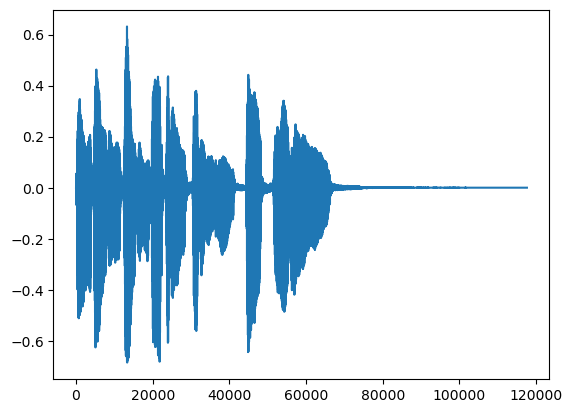

spectrogram:  (513, 231)
shape mel_spec:  (128, 231)
centers:  (25, 128)
## predict ##
X:  (231, 128)
x:  (231, 128)
centers:  (25, 128)
y:  (231, 25)


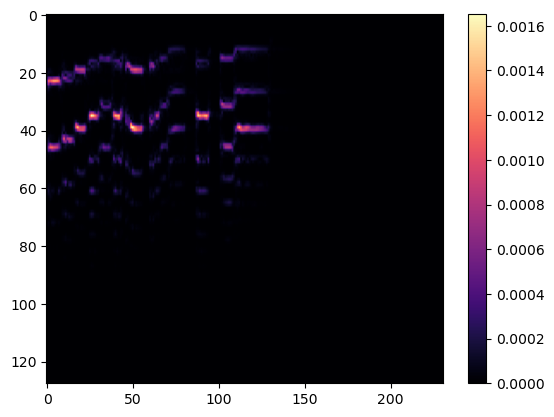

In [22]:
audio, sr = librosa.load(librosa.ex('trumpet'), sr=None)
print(audio.shape, sr)
plt.plot(audio)
plt.show()
rbf_activations, mel_spec = rbf_encode_audio(audio, sr, SFT=SFT)
plt.imshow(mel_spec, aspect='auto', cmap='magma')
plt.colorbar()
plt.show()

# play audio
ipd.Audio(audio, rate=sr)

(231, 25)
min max:  0.0 1.0


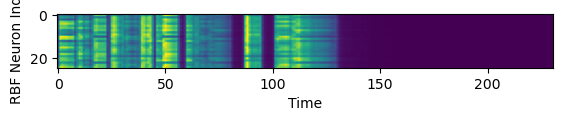

In [23]:
print(rbf_activations.shape)
print("min max: ", np.min(rbf_activations), np.max(rbf_activations))
plt.imshow(rbf_activations.T)
plt.xlabel('Time')
plt.ylabel('RBF Neuron Index')
plt.show()

rbf_activations_traversed shape:  (25, 231)
spike_probs shape:  (25, 231)


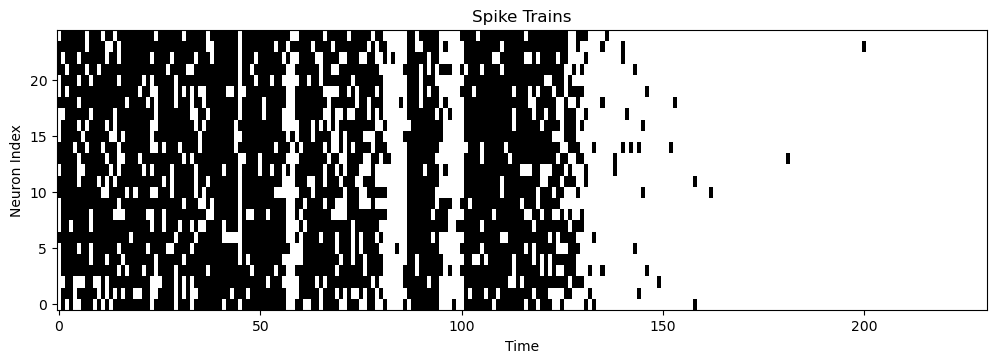

In [24]:
# convert the RBF activations to spikes
spike_prob_scale = 1.7

rbf_activations_traversed = rbf_activations.T
print("rbf_activations_traversed shape: ", rbf_activations_traversed.shape)
spik_probs = rbf_activations_traversed / np.max(rbf_activations_traversed, axis=1, keepdims=True) * spike_prob_scale 
print("spike_probs shape: ", spik_probs.shape)
# Generate Poisson-distributed spikes for the entire batch
spike_trains = np.random.poisson(spik_probs[...] * duration, size=rbf_activations_traversed.shape)

# Clip spike trains to binary values (0 or 1)
spike_trains = np.clip(spike_trains, 0, 1)

# Plot the spike trains
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.imshow(spike_trains, aspect='auto', origin='lower', cmap='binary')
plt.title('Spike Trains')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()

# SNN - sample STDP

In [16]:
EPOCHS = 20
batch_size = 32
nb_inputs = num_encoding_neurons
nb_hidden = 100
nb_out = 2

dtype = torch.float
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")


# stdp params
tau_pre = 2.
tau_post = 2.
T = 128
N = 1
lr = 0.01

spike_trains_all = np.concatenate((spike_trains_1, spike_trains_2), axis=0)
labels = np.concatenate((np.zeros(batch_size), np.ones(batch_size)))

# Convert to PyTorch tensors
spike_trains_all = torch.tensor(spike_trains_all, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# print shape of spike_trains and labels
print('spike_trains shape:', spike_trains_all.shape)
print('labels shape:', labels.shape)

# Create DataLoader
dataset = TensorDataset(spike_trains_all, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


def f_weight(x):
    return torch.clamp(x, -1, 1.)

net = nn.Sequential(
   layer.Linear(nb_inputs , nb_hidden, bias=False),
   neuron.IFNode(),
   layer.Linear(nb_hidden, nb_out, bias=False),
   neuron.IFNode(),
)

weight_scale = 0.2
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
w2 = torch.empty((nb_hidden, nb_out),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

# Define the STDP learning rule
stdp = learning.STDPLearner(step_mode='s', synapse=net[0], sn=net[1], tau_pre=tau_pre, tau_post=tau_post,
                                    f_pre=f_weight, f_post=f_weight)
stdp_out = learning.STDPLearner(step_mode='s', synapse=net[2], sn=net[3], tau_pre=tau_pre, tau_post=tau_post,
                                    f_pre=f_weight, f_post=f_weight)
# Define the optimizer
# optimizer = optim.Adam(net.parameters(), lr=lr)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

out_spike = []
trace_pre = []
trace_post = []
trace_pre_out = []
trace_post_out = []
weight_1 = []
weight_2 = []

for epoch in tqdm(range(EPOCHS), desc='Epochs', leave=True, total=EPOCHS):
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            # inputs = inputs.view(batch_size, -1)  # Flatten the inputs
            optimizer.zero_grad()
            for t in range(inputs.shape[-1]):
                out_spike.append(net(inputs[:,:,t]).squeeze())
                stdp.step(on_grad=True)  # Add ``- delta_w * scale`` on grad
                stdp_out.step(on_grad=True)  # Add ``- delta_w * scale`` on grad
                optimizer.step()
                weight_1.append(net[0].weight.data.clone().squeeze())
                weight_2.append(net[2].weight.data.clone().squeeze())
                trace_pre.append(stdp.trace_pre.squeeze())
                trace_post.append(stdp.trace_post.squeeze())
                trace_pre_out.append(stdp_out.trace_pre.squeeze())
                trace_post_out.append(stdp_out.trace_post.squeeze())

in_spikes = spike_trains_1.squeeze()
out_spike = torch.stack(out_spike)
trace_pre = torch.stack(trace_pre)
trace_post = torch.stack(trace_post)
trace_pre_out = torch.stack(trace_pre_out)
trace_post_out = torch.stack(trace_post_out)
weight_1 = torch.stack(weight_1)
weight_2 = torch.stack(weight_2)

spike_trains shape: torch.Size([64, 20, 1019])
labels shape: torch.Size([64])


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
print('in_spikes shape:', in_spikes.shape)
print('out_spike shape:', out_spike.shape)
print('trace_pre shape:', trace_pre.shape)
print('trace_post shape:', trace_post.shape)
print('weight shape:', weight_1.shape)
print('weight shape:', weight_2.shape)

in_spikes shape: (32, 20, 1019)
out_spike shape: torch.Size([40760, 32, 2])
trace_pre shape: torch.Size([40760, 32, 20])
trace_post shape: torch.Size([40760, 32, 100])
weight shape: torch.Size([40760, 100, 20])
weight shape: torch.Size([40760, 2, 100])


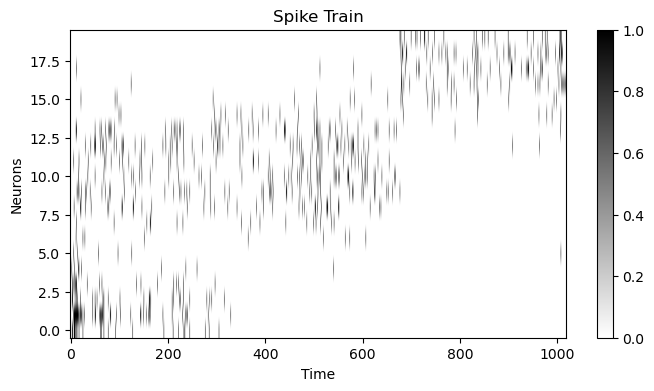

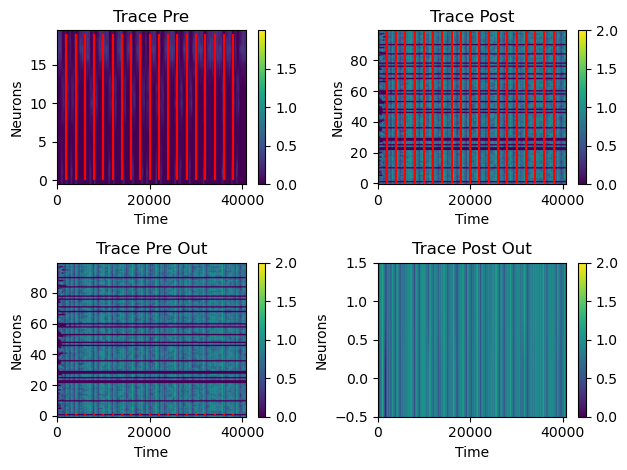

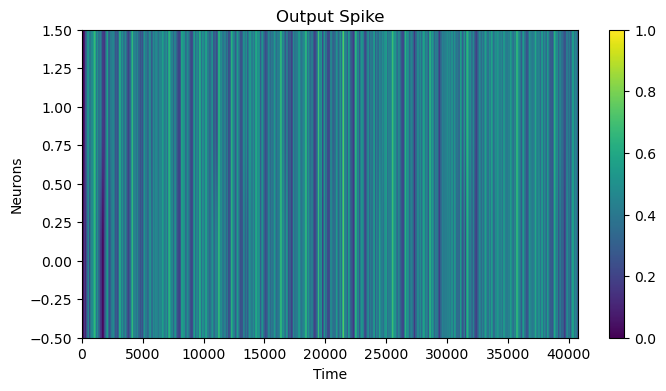

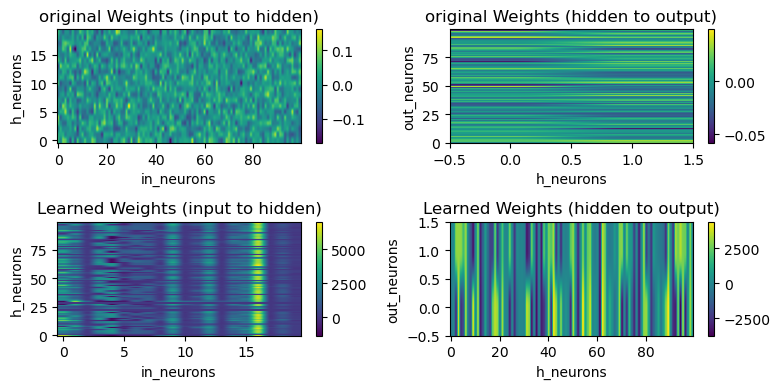

In [18]:
batch = 0

plt.figure(figsize=(8, 4))
plt.imshow(spike_trains_1[0,:,:], aspect='auto', origin='lower', cmap='binary')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Spike Train')
plt.colorbar()
plt.show()

plt.subplot(2,2,1)
plt.imshow(trace_pre[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Pre')
plt.colorbar()
# added vertical lines seperating epoches
plt.vlines(np.arange(num_samples, num_samples*EPOCHS, num_samples), ymin=0, ymax=nb_inputs-1, color='r')

plt.subplot(2,2,2)
plt.imshow(trace_post[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Post')
plt.colorbar()
plt.vlines(np.arange(num_samples, num_samples*EPOCHS, num_samples), ymin=0, ymax=nb_hidden-1, color='r')

plt.subplot(2,2,3)
plt.imshow(trace_pre_out[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Pre Out')
plt.colorbar()
plt.vlines(np.arange(num_samples, num_samples*EPOCHS, num_samples), ymin=0, ymax=nb_out-1, color='r')

plt.subplot(2,2,4)
plt.imshow(trace_post_out[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Trace Post Out')
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.imshow(out_spike[:,batch,:].T, aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.title('Output Spike')
plt.colorbar()
plt.show()


plt.figure(figsize=(8, 4))
plt.subplot(2,2,1)
plt.imshow(w1.detach(), aspect='auto', origin='lower')
plt.xlabel('in_neurons')
plt.ylabel('h_neurons')
plt.title('original Weights (input to hidden)')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(w2.detach(), aspect='auto', origin='lower')
plt.xlabel('h_neurons')
plt.ylabel('out_neurons')
plt.title('original Weights (hidden to output)')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(weight_1[-1], aspect='auto', origin='lower')
plt.xlabel('in_neurons')
plt.ylabel('h_neurons')
plt.title('Learned Weights (input to hidden)')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(weight_2[-1], aspect='auto', origin='lower')
plt.xlabel('h_neurons')
plt.ylabel('out_neurons')
plt.title('Learned Weights (hidden to output)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Read Out Layer (TODO)

In [19]:
# Evaluation function
def evaluate_snn(net, dataloader):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = torch.zeros(inputs.shape[0], nb_out, device=device)
            for t in range(inputs.shape[-1]):
                outputs += net(inputs[:, :, t])
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Create a DataLoader for evaluation
eval_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Compute accuracy
accuracy = evaluate_snn(net, eval_dataloader)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 50.00%


Epoch 0 Accuracy: 50.0000%
Epoch 1 Accuracy: 59.3750%
Epoch 2 Accuracy: 50.0000%
Epoch 3 Accuracy: 50.0000%
Epoch 4 Accuracy: 50.0000%
Epoch 5 Accuracy: 50.0000%
Epoch 6 Accuracy: 50.0000%
Epoch 7 Accuracy: 51.5625%
Epoch 8 Accuracy: 50.0000%
Epoch 9 Accuracy: 14.0625%
Epoch 10 Accuracy: 21.8750%
Epoch 11 Accuracy: 50.0000%
Epoch 12 Accuracy: 50.0000%
Epoch 13 Accuracy: 37.5000%
Epoch 14 Accuracy: 50.0000%
Epoch 15 Accuracy: 50.0000%
Epoch 16 Accuracy: 50.0000%
Epoch 17 Accuracy: 48.4375%
Epoch 18 Accuracy: 45.3125%
Epoch 19 Accuracy: 54.6875%


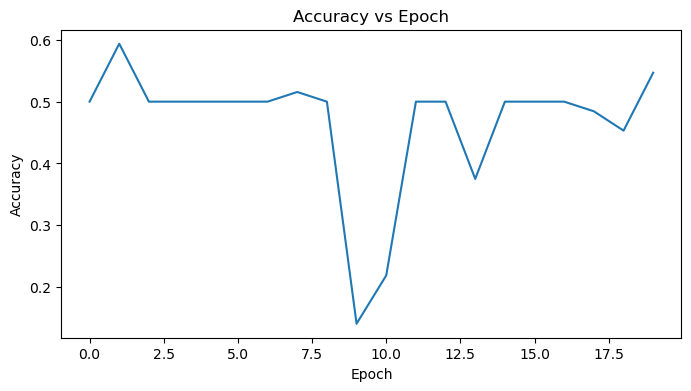

In [20]:
# eval the network on with its weights from different epochs
accuracy_list = []
for i in range(0, EPOCHS):
    net[0].weight.data = weight_1[i*num_samples - 1]
    net[2].weight.data = weight_2[i*num_samples - 1]
    accuracy = evaluate_snn(net, eval_dataloader)
    print(f'Epoch {i} Accuracy: {accuracy * 100:.4f}%')
    accuracy_list.append(accuracy)

plt.figure(figsize=(8, 4))
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.show()

# play audio